~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/path-foundation/blob/master/notebooks/fine_tune_data_efficient_classifier.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/path-foundation/blob/master/notebooks/fine_tune_data_efficient_classifier.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/path-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
  <td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fcxr-foundation%2Fmaster%2Fnotebooks%2Ffine_tune_data_efficient_classifier.ipynb">
    <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
  </a>
</td>
</tr></tbody></table>


# Fine-tuning the Hugging Face Pathology Model for Classification

This notebook demonstrates how to fine-tune the Hugging Face `path-foundation` model for binary classification of pathology images. It uses a subset of the [CAMELYON16](https://camelyon16.grand-challenge.org/) dataset (containing lymph node images) to train the model to distinguish between cancerous and benign tissues. The notebook covers the entire workflow: downloading and preparing the dataset, fine-tuning the pre-trained model using TensorFlow and Keras, and finally, evaluating the model's performance on a held-out evaluation set.

**Additional details**: For this demo, patches sampled from whole slide images (WSIs) are downloaded from Google Cloud Storage. A subset of the patches will be sampled randomly from across all available slides and be prepared for finetuning.

**Dataset**: This notebook uses the [CAMELYON16](https://camelyon16.grand-challenge.org/) dataset, which contains WSIs from lymph node specimens with and without metastatic breast cancer. Any work that uses this dataset should consider additional details along with usage and citation requirements listed on [their website](https://camelyon17.grand-challenge.org/Data/).

**Dataset citation**: Babak Ehteshami Bejnordi; Mitko Veta; Paul Johannes van Diest; Bram van Ginneken; Nico Karssemeijer; Geert Litjens; Jeroen A. W. M. van der Laak; and the CAMELYON16 Consortium. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA. 2017;318(22):2199–2210. DOI: 10.1001/jama.2017.14585

> **NOTE:** This colab which trains a classifier by fine-tuning the HuggingFace model takes a long time to run.

In [ ]:
# @title Authenticate with Hugging Face
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
  from huggingface_hub import notebook_login
  notebook_login()
else:
  print('Token already set.')

In [ ]:
# @title Fetch HuggingFace model
%%capture
from huggingface_hub import from_pretrained_keras
model_hf = from_pretrained_keras('google/path-foundation', compile=False)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# prompt: load this file /content/drive/MyDrive/AI4Thyroid/Tanzania-Data/TAN_THYROID_summary with surgery diagnosis in number.csv

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI4Thyroid/Tanzania-Data/TAN_THYROID_summary with surgery diagnosis in number.csv')
print(df.head())

   Unnamed: 0.1  Unnamed: 0 Scan ID Cytology no. Diagnosis/Bethesda system  \
0             0           0  TAN001      C-11-22                 Malignant   
1             1           1  TAN002      C-20-22             Benign nodule   
2             2           2  TAN003      C-53-23             Benign nodule   
3             3           3  TAN004      C-36-23             Benign nodule   
4             4           4  TAN005     C-373-20             Benign nodule   

   Bethesda actual         Histopathology  Surgery diagnosis in number  \
0                6   Anaplastic carcinoma                          1.0   
1                2  Simple Nodular Goitre                          0.0   
2                2  Simple Nodular Goitre                          0.0   
3                2  Simple Nodular Goitre                          0.0   
4                2  Simple Nodular Goitre                          0.0   

   Present Present (Manual)  
0        1            exist  
1        1            exis

In [5]:
# prompt: drop rows without value in "Surgery diagnosis in number", stratified split into 2 groups, training and evaluation, and print out statistic of each group

from sklearn.model_selection import train_test_split

# Drop rows where 'Surgery diagnosis in number' is missing
df_cleaned = df.dropna(subset=['Surgery diagnosis in number']).copy()

# Stratified split
train_df, eval_df = train_test_split(
    df_cleaned,
    test_size=0.2,  # You can adjust the size of the evaluation set
    stratify=df_cleaned['Surgery diagnosis in number'],
    random_state=42 # for reproducibility
)

print("\n--- Training Group Statistics ---")
print(train_df['Surgery diagnosis in number'].value_counts(normalize=True))
print(f"Total samples in training group: {len(train_df)}")

print("\n--- Evaluation Group Statistics ---")
print(eval_df['Surgery diagnosis in number'].value_counts(normalize=True))
print(f"Total samples in evaluation group: {len(eval_df)}")


--- Training Group Statistics ---
Surgery diagnosis in number
0.0    0.9
1.0    0.1
Name: proportion, dtype: float64
Total samples in training group: 80

--- Evaluation Group Statistics ---
Surgery diagnosis in number
0.0    0.9
1.0    0.1
Name: proportion, dtype: float64
Total samples in evaluation group: 20


In [6]:
# prompt: each patient has a Scan ID value. There is also a folder with the same name as the Scan ID value in this path /content/drive/MyDrive/AI4Thyroid/Tanzania-Data. Inside the folder are images of the patient. Add a column to the train_df and eval_df storing paths to images, each path on a row

import os

base_image_path = '/content/drive/MyDrive/AI4Thyroid/Tanzania-Data'

def get_image_paths(row):
    scan_id = row['Scan ID']
    folder_path = os.path.join(base_image_path, str(scan_id))
    image_paths = []
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            # Assuming image files have common extensions
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_paths.append(os.path.join(folder_path, filename))
    # Store paths as a list in the DataFrame cell
    return image_paths

train_df['image_paths'] = train_df.apply(get_image_paths, axis=1)
eval_df['image_paths'] = eval_df.apply(get_image_paths, axis=1)

# Display the first few rows to verify
print("\n--- Training Group with Image Paths ---")
print(train_df[['Scan ID', 'image_paths']].head())

print("\n--- Evaluation Group with Image Paths ---")
print(eval_df[['Scan ID', 'image_paths']].head())


--- Training Group with Image Paths ---
    Scan ID                                        image_paths
36   TAN037  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
91   TAN092  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
76   TAN077  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
77   TAN078  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
104  TAN105  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...

--- Evaluation Group with Image Paths ---
   Scan ID                                        image_paths
95  TAN096  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
84  TAN085  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
96  TAN097  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
57  TAN058  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...
2   TAN003  [/content/drive/MyDrive/AI4Thyroid/Tanzania-Da...


In [7]:
# prompt: modify the train_df and eval_df so that each row has just one image path

# Modify the dataframes to have one row per image path
train_df = train_df.explode('image_paths')
eval_df = eval_df.explode('image_paths')

# Display the first few rows to verify the modification
print("\n--- Training Group with one row per Image Path ---")
print(train_df[['Scan ID', 'image_paths', 'Surgery diagnosis in number']].head())

print("\n--- Evaluation Group with one row per Image Path ---")
print(eval_df[['Scan ID', 'image_paths', 'Surgery diagnosis in number']].head())

# Print total number of images in each set
print(f"\nTotal number of images in training set: {len(train_df)}")
print(f"Total number of images in evaluation set: {len(eval_df)}")


--- Training Group with one row per Image Path ---
   Scan ID                                        image_paths  \
36  TAN037  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
36  TAN037  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
36  TAN037  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
36  TAN037  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
36  TAN037  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   

    Surgery diagnosis in number  
36                          0.0  
36                          0.0  
36                          0.0  
36                          0.0  
36                          0.0  

--- Evaluation Group with one row per Image Path ---
   Scan ID                                        image_paths  \
95  TAN096  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
95  TAN096  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
95  TAN096  /content/drive/MyDrive/AI4Thyroid/Tanzania-Dat...   
95  TAN096  /content/drive/MyDrive/AI4T

In [8]:
# prompt: save train_df and eval_df to csv file

# Define the output directory and filenames
output_dir = '/content/drive/MyDrive/AI4Thyroid/ProcessedData'
train_csv_path = os.path.join(output_dir, 'train_dataset.csv')
eval_csv_path = os.path.join(output_dir, 'eval_dataset.csv')

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the dataframes to CSV files
train_df.to_csv(train_csv_path, index=False)
eval_df.to_csv(eval_csv_path, index=False)

print(f"\nTraining dataset saved to: {train_csv_path}")
print(f"Evaluation dataset saved to: {eval_csv_path}")


Training dataset saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/train_dataset.csv
Evaluation dataset saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/eval_dataset.csv


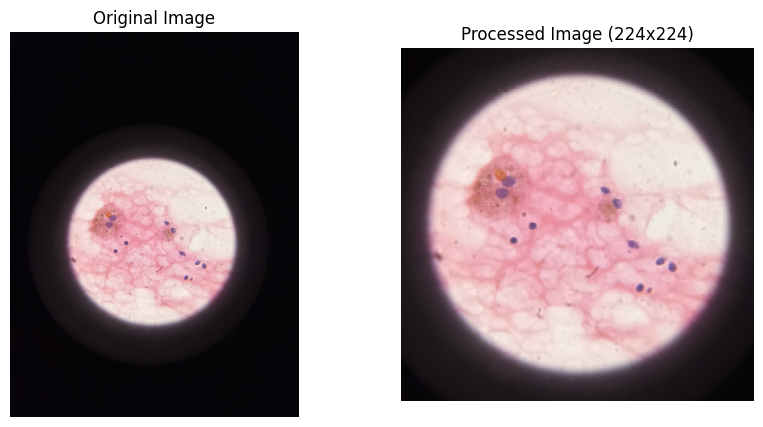

Original image shape: (4096, 3072, 3)
Processed image shape: (224, 224, 3)
Processed tensor shape: (1, 224, 224, 3)


In [9]:
# prompt: Define a function that removes as much as possible black background in an image using global thresholding and resize to 224x224 pixels and convert to a tensor and return. Select an image from train_dataset.csv and call the function. Display the image before and after calling the function.

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """
    Removes black background, resizes, and converts an image to a tensor.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: A tuple containing:
            - tf.Tensor: The processed image as a tensor (224x224x3).
            - np.ndarray: The original image as a NumPy array.
            - np.ndarray: The processed image as a NumPy array.
    """
    # Load the image using Pillow
    original_img = Image.open(image_path).convert('RGB')
    original_img_np = np.array(original_img)

    # Convert to grayscale for thresholding
    gray_img = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2GRAY)

    # Apply global thresholding to create a mask of non-black pixels
    # Assuming black is close to 0. Adjust threshold if necessary.
    _, thresh = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Find the bounding box of the largest contour (likely the main object)
    if contours:
        # Find the contour with the maximum area
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the original image based on the bounding box
        cropped_img_np = original_img_np[y:y+h, x:x+w]
    else:
        # If no significant contours are found, use the original image
        cropped_img_np = original_img_np

    # Resize the cropped image to 224x224
    resized_img_np = cv2.resize(cropped_img_np, (224, 224), interpolation=cv2.INTER_AREA)

    # Convert the NumPy array to a TensorFlow tensor
    # Add a batch dimension and scale pixel values to [0, 1] if needed by the model
    processed_tensor = tf.convert_to_tensor(resized_img_np, dtype=tf.float32)
    # If the model expects values in [0, 1]:
    processed_tensor = processed_tensor / 255.0
    processed_tensor = tf.expand_dims(processed_tensor, axis=0) # Add batch dimension

    return processed_tensor, original_img_np, resized_img_np

# Load the training dataset CSV
train_dataset_path = '/content/drive/MyDrive/AI4Thyroid/ProcessedData/train_dataset.csv'
train_df = pd.read_csv(train_dataset_path)

# Select an image path from the training dataset (e.g., the first one)
if not train_df.empty and 'image_paths' in train_df.columns:
    selected_image_path = train_df['image_paths'].iloc[0]

    # Call the function to process the image
    processed_tensor, original_image_np, processed_image_np = preprocess_image(selected_image_path)

    # Display the original and processed images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image_np)
    plt.title("Processed Image (224x224)")
    plt.axis('off')

    plt.show()

    print(f"Original image shape: {original_image_np.shape}")
    print(f"Processed image shape: {processed_image_np.shape}")
    print(f"Processed tensor shape: {processed_tensor.shape}")

else:
    print("Training dataframe is empty or 'image_paths' column not found.")
    print("Please ensure 'train_dataset.csv' exists and contains image paths.")

In [10]:
# prompt: using the above preprocess_image function, create a train_images tensor from "image paths" in train_dataset.csv, showing progress during the process

import pandas as pd
from tqdm.auto import tqdm

# Load the training dataset CSV again just in case
train_dataset_path = '/content/drive/MyDrive/AI4Thyroid/ProcessedData/train_dataset.csv'
train_df = pd.read_csv(train_dataset_path)

# List to store processed image tensors
train_image_tensors = []

# Iterate through each image path in the training dataframe with a progress bar
print("Preprocessing training images...")
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    image_path = row['image_paths']
    if pd.notna(image_path) and os.path.exists(image_path):
        try:
            # Process the image using the function defined earlier
            processed_tensor, _, _ = preprocess_image(image_path)
            train_image_tensors.append(processed_tensor)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    else:
        print(f"Warning: Image path not found or is NaN: {image_path}")


# Concatenate all individual tensors into a single tensor
if train_image_tensors:
    train_images = tf.concat(train_image_tensors, axis=0)
    print(f"\nFinished preprocessing. train_images tensor created with shape: {train_images.shape}")
else:
    train_images = tf.constant([], dtype=tf.float32) # Create an empty tensor if no images were processed
    print("\nNo training images were successfully processed.")

# You can now use `train_images` for model training

Preprocessing training images...


  0%|          | 0/960 [00:00<?, ?it/s]


Finished preprocessing. train_images tensor created with shape: (960, 224, 224, 3)


In [11]:
# prompt: create training_labels tensor from "surgery diagnosis in number" in train_dataset.csv

# Ensure the column name is correct
label_column = 'Surgery diagnosis in number'

if label_column in train_df.columns:
    # Extract the labels as a pandas Series
    train_labels_series = train_df[label_column]

    # Convert the Series to a NumPy array
    train_labels_np = train_labels_series.to_numpy()

    # Convert the NumPy array to a TensorFlow tensor
    # Use the appropriate data type for your labels (e.g., tf.int32, tf.float32)
    # If it's a binary classification (0 or 1), tf.int32 or tf.int64 is usually fine.
    # If it's for a regression task or requires floating point, use tf.float32.
    # Assuming diagnosis is an integer for classification
    training_labels = tf.convert_to_tensor(train_labels_np, dtype=tf.int64)

    print(f"\nTraining labels tensor created with shape: {training_labels.shape}")
    print(f"Training labels tensor data type: {training_labels.dtype}")
    print("Sample training labels:", training_labels[:10].numpy()) # Display a few sample labels

else:
    print(f"Error: Column '{label_column}' not found in the training dataframe.")
    print("Available columns:", train_df.columns.tolist())


Training labels tensor created with shape: (960,)
Training labels tensor data type: <dtype: 'int64'>
Sample training labels: [0 0 0 0 0 0 0 0 0 0]


In [12]:
# prompt: using the above preprocess_image function, create a eval_images tensor from "image paths" in eval_dataset.csv, showing progress during the process

import pandas as pd
# Load the evaluation dataset CSV
eval_dataset_path = '/content/drive/MyDrive/AI4Thyroid/ProcessedData/eval_dataset.csv'
eval_df = pd.read_csv(eval_dataset_path)

# List to store processed image tensors for evaluation
eval_image_tensors = []

# Iterate through each image path in the evaluation dataframe with a progress bar
print("Preprocessing evaluation images...")
for index, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
    image_path = row['image_paths']
    if pd.notna(image_path) and os.path.exists(image_path):
        try:
            # Process the image using the preprocess_image function
            processed_tensor, _, _ = preprocess_image(image_path)
            eval_image_tensors.append(processed_tensor)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    else:
        print(f"Warning: Image path not found or is NaN: {image_path}")

# Concatenate all individual tensors into a single tensor for evaluation
if eval_image_tensors:
    eval_images = tf.concat(eval_image_tensors, axis=0)
    print(f"\nFinished preprocessing. eval_images tensor created with shape: {eval_images.shape}")
else:
    eval_images = tf.constant([], dtype=tf.float32) # Create an empty tensor if no images were processed
    print("\nNo evaluation images were successfully processed.")

# You can now use `eval_images` for model evaluation or inference

# Extract labels for the evaluation set as well
if label_column in eval_df.columns:
    # Extract the labels as a pandas Series
    eval_labels_series = eval_df[label_column]

    # Convert the Series to a NumPy array
    eval_labels_np = eval_labels_series.to_numpy()

    # Convert the NumPy array to a TensorFlow tensor
    evaluation_labels = tf.convert_to_tensor(eval_labels_np, dtype=tf.int64)

    print(f"\nEvaluation labels tensor created with shape: {evaluation_labels.shape}")
    print(f"Evaluation labels tensor data type: {evaluation_labels.dtype}")
    print("Sample evaluation labels:", evaluation_labels[:10].numpy()) # Display a few sample labels

else:
    print(f"Error: Column '{label_column}' not found in the evaluation dataframe.")
    print("Available columns:", eval_df.columns.tolist())

Preprocessing evaluation images...


  0%|          | 0/269 [00:00<?, ?it/s]


Finished preprocessing. eval_images tensor created with shape: (269, 224, 224, 3)

Evaluation labels tensor created with shape: (269,)
Evaluation labels tensor data type: <dtype: 'int64'>
Sample evaluation labels: [0 0 0 0 0 0 0 0 0 0]


In [46]:
# prompt: save the train_images, training_labels, eval_images, evaluation_labels to this folder /content/drive/MyDrive/AI4Thyroid/ProcessedData

import numpy as np
# Define the directory where you want to save the files
output_dir = '/content/drive/MyDrive/AI4Thyroid/ProcessedData'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the file paths for saving the tensors
train_images_path = os.path.join(output_dir, 'train_images.npy')
training_labels_path = os.path.join(output_dir, 'training_labels.npy')
eval_images_path = os.path.join(output_dir, 'eval_images.npy')
evaluation_labels_path = os.path.join(output_dir, 'evaluation_labels.npy')

# Convert TensorFlow tensors to NumPy arrays before saving
train_images_np = train_images.numpy()
training_labels_np = training_labels.numpy()
eval_images_np = eval_images.numpy()
evaluation_labels_np = evaluation_labels.numpy()

# Save the NumPy arrays
np.save(train_images_path, train_images_np)
np.save(training_labels_path, training_labels_np)
np.save(eval_images_path, eval_images_np)
np.save(evaluation_labels_path, evaluation_labels_np)

print(f"train_images saved to: {train_images_path}")
print(f"training_labels saved to: {training_labels_path}")
print(f"eval_images saved to: {eval_images_path}")
print(f"evaluation_labels saved to: {evaluation_labels_path}")


train_images saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/train_images.npy
training_labels saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/training_labels.npy
eval_images saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/eval_images.npy
evaluation_labels saved to: /content/drive/MyDrive/AI4Thyroid/ProcessedData/evaluation_labels.npy


In [24]:
# @title Configure model for classification and prepare data for training
import numpy as np

import tensorflow as tf
from tf_keras import Sequential
from tf_keras.models import Model
from tf_keras.layers import Dense, Layer, Dropout
from tf_keras.optimizers import Adam
from tf_keras.utils import to_categorical
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping

class EmbeddingLayer(Layer):
  """A custom Keras layer that wraps a pre-trained embedding model for fine-tuning."""

  def __init__(self, model, **kwargs):
    """ Initialize the EmbeddingLayer with a pre-trained model. """
    super().__init__(**kwargs)
    self.embedding_model = model

  @tf.function
  def call(self, inputs):
    """ Compute embeddings by passing inputs through the embedding model. """
    return self.embedding_model(inputs)

  def get_config(self):
      """Returns the config of the layer."""
      base_config = super(EmbeddingLayer, self).get_config()
      config = {
          "embedding_model": tf.keras.utils.serialize_keras_object(self.embedding_model),
      }
      return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
      """Creates a layer from its config."""
      from tf_keras.models import model_from_config
      embedding_model_config = config.pop("embedding_model")
      embedding_model = tf.keras.utils.deserialize_keras_object(embedding_model_config)
      return cls(embedding_model, **config)


def train(model, learning_rate=1e-4):
    # Callbacks:
    # - ReduceLROnPlateau lowers the learning rate when val_loss stops improving.
    # - EarlyStopping stops training early if val_loss doesn't improve, restoring the best weights.
    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    with tf.device('/GPU:0'):
      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
      print('Start training model')
      model.build(input_shape=(None, 224, 224, 3))  # To be able to display summary
      model.summary(expand_nested=True, show_trainable=True)
      model.fit(
          train_images,
          to_categorical(training_labels, num_classes=NUM_CLASSES),
          epochs=40,
          batch_size=64,
          validation_data=(
              eval_images,
              to_categorical(evaluation_labels, num_classes=NUM_CLASSES)
          ),
          callbacks=[lr_callback, early_stopping]
      )

# Total number of classes for classification.
NUM_CLASSES = 2


# Wrap the pre-trained model in a custom embedding layer
embedding_layer = EmbeddingLayer(model_hf, name='embedding')

# Add a dense output layer for classification
classification_layer = Dense(NUM_CLASSES, activation='softmax', dtype='float32', name='classification_output')

# Build the new sequential model for pathology image classification,
# consisting of an embedding layer, dropout for regularization, and a classification layer.
new_model = Sequential([embedding_layer, Dropout(0.1), classification_layer], name='path_classifer')

# Combine cancer and benign images into a single training dataset, assigning labels:
# 1 for cancer images, 0 for benign images.
#training_images = tf.concat(training_cancer_normalized_images + training_benign_normalized_images, axis=0)
#training_labels = tf.constant([1] * len(training_cancer_normalized_images) + [0] * len(training_benign_normalized_images))

# Similarly, prepare evaluation images and labels.
#eval_images = tf.concat(eval_cancer_normalized_images + eval_benign_normalized_images, axis=0)
#eval_labels = tf.constant([1] * len(eval_cancer_normalized_images) + [0] * len(eval_benign_normalized_images))


In [45]:
# prompt: modify the model to improve accuracy for class 1

import numpy as np
import tensorflow as tf
from tf_keras.optimizers import Adam
from tf_keras.utils import to_categorical
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tf_keras import Sequential
from tf_keras.layers import Dense, Layer, Dropout
from sklearn.utils import class_weight # Import class_weight here
from tf_keras.losses import CategoricalCrossentropy # Import the loss function

class EmbeddingLayer(Layer):
  """A custom Keras layer that wraps a pre-trained embedding model for fine-tuning."""

  def __init__(self, model, **kwargs):
    """ Initialize the EmbeddingLayer with a pre-trained model. """
    super().__init__(**kwargs)
    self.embedding_model = model

  @tf.function
  def call(self, inputs):
    """ Compute embeddings by passing inputs through the embedding model. """
    return self.embedding_model(inputs)

  def get_config(self):
      """Returns the config of the layer."""
      base_config = super(EmbeddingLayer, self).get_config()
      config = {
          "embedding_model": tf.keras.utils.serialize_keras_object(self.embedding_model),
      }
      return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
      """Creates a layer from its config."""
      from tf_keras.models import model_from_config
      embedding_model_config = config.pop("embedding_model")
      embedding_model = tf.keras.utils.deserialize_keras_object(embedding_model_config)
      return cls(embedding_model, **config)


def train(model, learning_rate=1e-4):
    # Callbacks:
    # - ReduceLROnPlateau lowers the learning rate when val_loss stops improving.
    # - EarlyStopping stops training early if val_loss doesn't improve, restoring the best weights.
    # Add class weights to the model training
    # Assuming class 1 is the minority class that needs improved accuracy
    # Calculate class weights

    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(training_labels.numpy()),
        y=training_labels.numpy()
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Calculated class weights:", class_weights_dict)

    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # Increased patience
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1) # Increased patience

    # Define optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Define loss function with from_logits=False since we are using softmax activation
    loss_fn = CategoricalCrossentropy(from_logits=False)

    print('Start training model with custom training loop')
    model.build(input_shape=(None, 224, 224, 3))
    model.summary(expand_nested=True, show_trainable=True)

    # Convert labels to one-hot encoding
    training_labels_one_hot = to_categorical(training_labels, num_classes=NUM_CLASSES)
    evaluation_labels_one_hot = to_categorical(evaluation_labels, num_classes=NUM_CLASSES)

    # Create TensorFlow Datasets for training and validation
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, training_labels_one_hot)).shuffle(1000).batch(32)
    eval_dataset = tf.data.Dataset.from_tensor_slices((eval_images, evaluation_labels_one_hot)).batch(32)

    eval_accuracy_history = []

    for epoch in range(100): # Increased epochs
        print(f"\nEpoch {epoch+1}/100")

        # Training loop
        train_loss = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        train_precision = tf.keras.metrics.Precision(class_id=1)
        train_recall = tf.keras.metrics.Recall(class_id=1)


        for step, (images, labels) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(images, training=True)
                loss = loss_fn(labels, predictions)
                # Apply class weights to the loss
                sample_weights = tf.gather(tf.constant(list(class_weights_dict.values()), dtype=tf.float32), tf.argmax(labels, axis=1))
                loss = loss * sample_weights

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss.update_state(loss)
            train_accuracy.update_state(labels, predictions)
            train_precision.update_state(labels, predictions)
            train_recall.update_state(labels, predictions)

            if step % 10 == 0: # Print progress every 10 steps
                print(f"  Step {step}: Loss = {train_loss.result():.4f}, Accuracy = {train_accuracy.result():.4f}, Precision (Class 1) = {train_precision.result():.4f}, Recall (Class 1) = {train_recall.result():.4f}")


        # Validation loop
        eval_loss = tf.keras.metrics.Mean()
        eval_accuracy = tf.keras.metrics.CategoricalAccuracy()
        eval_precision = tf.keras.metrics.Precision(class_id=1)
        eval_recall = tf.keras.metrics.Recall(class_id=1)


        for images, labels in eval_dataset:
            predictions = model(images, training=False)
            loss = loss_fn(labels, predictions)

            eval_loss.update_state(loss)
            eval_accuracy.update_state(labels, predictions)
            eval_precision.update_state(labels, predictions)
            eval_recall.update_state(labels, predictions)

        print(f"Epoch {epoch+1} Metrics:")
        print(f"  Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result():.4f}, Train Precision (Class 1): {train_precision.result():.4f}, Train Recall (Class 1): {train_recall.result():.4f}")
        print(f"  Eval Loss: {eval_loss.result():.4f}, Eval Accuracy: {eval_accuracy.result():.4f}, Eval Precision (Class 1): {eval_precision.result():.4f}, Eval Recall (Class 1): {eval_recall.result():.4f}")

        # Check for early stopping based on validation accuracy
        # Note: This is a simplified early stopping check. For a full implementation,
        # you would track the best validation accuracy and restore weights.
        # This version just prints a message if improvement stalls.
        if epoch > 0 and eval_accuracy.result() <= eval_accuracy_history[-1]:
            print("Validation accuracy did not improve.")
        # Append current eval accuracy to a history list to implement basic early stopping logic
        # (This requires initializing an empty list `eval_accuracy_history` before the epoch loop)
        # Example: eval_accuracy_history = []
        eval_accuracy_history.append(eval_accuracy.result())


# Total number of classes for classification.
NUM_CLASSES = 2

# Wrap the pre-trained model in a custom embedding layer
embedding_layer = EmbeddingLayer(model_hf, name='embedding')

# Add a dense output layer for classification
# Consider adding more complexity or different activation for the final layer if needed
classification_layer = Dense(NUM_CLASSES, activation='softmax', dtype='float32', name='classification_output')

# Build the new sequential model for pathology image classification,
# consisting of an embedding layer, dropout for regularization, and a classification layer.
# Increased dropout rate for potentially better regularization
new_model = Sequential([embedding_layer, Dropout(0.3), classification_layer], name='path_classifer')

# Freeze the embedding layer and train only the new classification layer.
embedding_layer.trainable = False
classification_layer.trainable = True
# Train the model with the updated function including class weights and metrics
train(new_model, learning_rate=5e-5) # Consider slightly lower learning rate

Calculated class weights: {0: np.float64(0.5647058823529412), 1: np.float64(4.363636363636363)}
Start training model with custom training loop
Model: "path_classifer"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 embedding (EmbeddingLayer)  (None, 384)               2745984   N          
                                                       0                    
                                                                            
 dropout_8 (Dropout)         (None, 384)               0         Y          
                                                                            
 classification_output (Den  (None, 2)                 770       Y          
 se)                                                                        
                                                                            
Total params: 27460610 (104.75 MB)
Trainable params: 770 (3.01 

KeyboardInterrupt: 

In [43]:
# @title Train the classification layer

print("""
  Fine-tuning this model takes a while (~3 hours on CPU),
  depending on your Colab runtime's resources. Please be patient.
  """)

# Freeze the embedding layer and train only the new classification layer.
embedding_layer.trainable = False
classification_layer.trainable = True
train(new_model, learning_rate=1e-3)




  Fine-tuning this model takes a while (~3 hours on CPU),
  depending on your Colab runtime's resources. Please be patient.
  
Calculated class weights: {0: np.float64(0.5647058823529412), 1: np.float64(4.363636363636363)}


AttributeError: 'Variable' object has no attribute '_distribute_strategy'

In [26]:
# @title Unfreeze the layer containing the HuggingFace model and fine-tune the combined model

# Unfreeze the pretrained embedding layer to futher improve model for this task.
before_weights = new_model.layers[0].embedding_model.variables[0][0, 0, :10].numpy()
embedding_layer.trainable = True
classification_layer.trainable = True
train(new_model, 1e-5)

print('\n### Did weights change?')
print('Before sample weights from embedding layer:\n', before_weights)
print('Same weights after fine-tuning:\n', new_model.layers[0].embedding_model.variables[0][0, 0, :10].numpy())

# Save the fine-tuned model to disk
tf.saved_model.save(new_model, 'fine_tuned_model')

Start training model
Model: "path_classifer"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 embedding (EmbeddingLayer)  (None, 384)               2745984   Y          
                                                       0                    
                                                                            
 dropout_1 (Dropout)         (None, 384)               0         Y          
                                                                            
 classification_output (Den  (None, 2)                 770       Y          
 se)                                                                        
                                                                            
Total params: 27460610 (104.75 MB)
Trainable params: 27460610 (104.75 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________________________

In [34]:
# @title Perform Inference using the Fine-tuned Model

# Load the fine-tuned model from disk
model_finetuned = tf.saved_model.load('fine_tuned_model')

np.set_printoptions(formatter={'float_kind': lambda x: "{:.6f}".format(x)})

eval_predictions = []
eval_ground_truth = []

print('\n\nEach prediction is a probability distribution over [benign, cancer].')
print('For example: [0.123, 0.877] means a ~12.3% chance benign and ~87.7% chance cancer.')
print('\n\nRun prediction for eval set:')

print('=== Ground truth:')
for image, label in zip(eval_images, evaluation_labels):
  # display the image with label

  # Add batch dimension to the image tensor before prediction
  image_with_batch = tf.expand_dims(image, axis=0)

  prediction = model_finetuned(image_with_batch).numpy()
  eval_predictions.append(np.argmax(prediction))
  eval_ground_truth.append(label)  # 1 for cancer
  print(f'Predictions: {np.argmax(prediction)}, Ground truth: {label}')



Each prediction is a probability distribution over [benign, cancer].
For example: [0.123, 0.877] means a ~12.3% chance benign and ~87.7% chance cancer.


Run prediction for eval set:
=== Ground truth:
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth: 0
Predictions: 0, Ground truth:

In [36]:
# prompt: create classification report

import numpy as np
from sklearn.metrics import classification_report

print("\n--- Evaluation Classification Report ---")
# Ensure ground truth and predictions are numpy arrays
eval_ground_truth_np = np.array(eval_ground_truth)
eval_predictions_np = np.array(eval_predictions)

# Generate and print the classification report
# target_names are optional, you can define them if you know your class labels
# For binary classification with labels 0 and 1, you might use ['benign', 'cancer']
target_names = ['benign', 'cancer']
print(classification_report(eval_ground_truth_np, eval_predictions_np, target_names=target_names))


--- Evaluation Classification Report ---
              precision    recall  f1-score   support

      benign       0.88      1.00      0.93       236
      cancer       0.00      0.00      0.00        33

    accuracy                           0.88       269
   macro avg       0.44      0.50      0.47       269
weighted avg       0.77      0.88      0.82       269



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


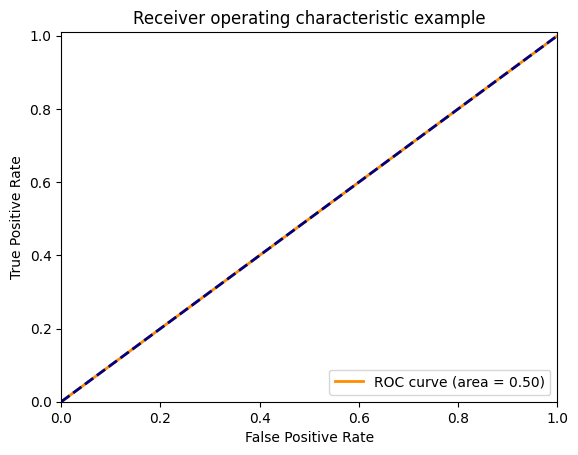

AUC score: 0.5


In [35]:
# @title Plot AUC graph

import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(eval_ground_truth, eval_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print('AUC score:',sklearn.metrics.roc_auc_score(eval_ground_truth, eval_predictions))

In [29]:
import sklearn.metrics
import numpy as np

# @title Find Youden's index for threshold selection

thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []

# Convert eval_ground_truth to a NumPy array
eval_ground_truth_array = np.array(eval_ground_truth)

# Iterate through thresholds and calculate sensitivity and specificity for each
for threshold in thresholds:
  predictions = np.array(eval_predictions) > threshold  # Convert predictions to NumPy array
  sensitivities.append(sklearn.metrics.recall_score(eval_ground_truth_array, predictions))
  specificities.append(
      sklearn.metrics.recall_score(eval_ground_truth_array == 0, predictions == 0)
  )

# Find the index of the maximum Youden's index
index = np.argmax(np.array(sensitivities) + np.array(specificities))
best_threshold = thresholds[index]
sens = sensitivities[index]
spec = specificities[index]
print(
    f"\n\nBest threshold: {round(best_threshold,2)}. Sensitivity is"
    f" {round(sens*100,2)}% and Specificity is {round(spec*100,2)}% "
)



Best threshold: 0.02. Sensitivity is 45.45% and Specificity is 75.42% 


# Next steps

 Explore the other [notebooks](https://github.com/google-health/path-foundation/blob/master/notebooks).

In [ ]:
# Install the full version of OpenCV with contributions
!pip install opencv-contrib-python